In [2]:
import json
import os
from pathlib import Path

Read NPZ files

In [3]:

from numpy import load

data = load('../data/processed/hpo2hpo_rec.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

print("Total non-zero values:", len(data['data']))

row
[    0     0     0 ... 19033 19033 19033]
col
[   1    5  135 ... 1341 1556 1842]
format
np.bytes_(b'coo')
shape
[19034 19034]
data
[1. 1. 1. ... 1. 1. 1.]
Total non-zero values: 390790


In [21]:
from numpy import load

# Load the data
data = load('../data/processed/g2hpo.npz')

# Extract necessary information
num_rows = data['shape'][0]  # Total rows in the matrix
num_cols = data['shape'][1]  # Total columns in the matrix
num_nonzeros = len(data['data'])  # Total non-zero values

# Calculate averages
avg_sum_rows = num_nonzeros / num_rows
avg_sum_cols = num_nonzeros / num_cols

print(f"Average sum of rows: {avg_sum_rows}")
print(f"Average sum of columns: {avg_sum_cols}")

Average sum of rows: 45.875399534102606
Average sum of columns: 44.48954502469265


In [22]:
def count_missing_disease_ids():
    # File paths
    dis2hpo_file = '/home/abamini/PhenoGnet/data/processed/dis2hpo.txt'
    full_data_file = '/home/abamini/PhenoGnet/data/processed/full_dataset.txt'
    
    # Read disease IDs from dis2id.txt (2nd column, starting from 2nd row)
    disease_ids_from_mapping = set()
    with open(dis2hpo_file, 'r') as f:
        # Skip the header row
        next(f, None)
        for line in f:
            parts = line.strip().split(' ')
            if len(parts) >= 2:
                disease_ids_from_mapping.add(parts[1])
    
    # Read disease IDs from full_dataset.txt (1st and 2nd columns)
    disease_ids_from_dataset = set()
    with open(full_data_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                disease_ids_from_dataset.add(parts[0])
                disease_ids_from_dataset.add(parts[1])
    print(len(disease_ids_from_dataset))
    # Find disease IDs in full_dataset.txt that are not in dis2id.txt
    missing_disease_ids = disease_ids_from_dataset - disease_ids_from_mapping
    
    # Return the count and the missing IDs
    return len(missing_disease_ids), missing_disease_ids

# Execute the function and print results
count, missing_ids = count_missing_disease_ids()
print(f"Number of disease IDs in full_dataset.txt not present in dis2hpo.txt: {count}")



7190
Number of disease IDs in full_dataset.txt not present in dis2hpo.txt: 3787


In [23]:
# File paths
dis2hpo_file = '/home/abamini/PhenoGnet/data/processed/dis2hpo.txt'
full_data_file = '/home/abamini/PhenoGnet/data/processed/full_dataset.txt'
output_file = '/home/abamini/PhenoGnet/data/processed/full_dataset_edited.txt'

# Read disease IDs from dis2hpo.txt
disease_ids_from_mapping = set()
with open(dis2hpo_file, 'r') as f:
    next(f, None)  # Skip header
    for line in f:
        parts = line.strip().split(' ')
        if len(parts) >= 2:
            disease_ids_from_mapping.add(parts[1])

# Filter and save valid disease pairs
with open(full_data_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line in infile:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            disease_id_1, disease_id_2, binary_value = parts
            if disease_id_1 in disease_ids_from_mapping and disease_id_2 in disease_ids_from_mapping:
                outfile.write(line)

print("Filtered dataset saved to full_dataset_edited.txt")


Filtered dataset saved to full_dataset_edited.txt


In [5]:
import random

# File paths
dis2hpo_file = '/home/abamini/PhenoGnet/data/processed/dis2hpo.txt'
full_data_file = '/home/abamini/PhenoGnet/data/processed/full_dataset.txt'
filtered_file = '/home/abamini/PhenoGnet/data/processed/full_dataset_edited.txt'
train_file = '/home/abamini/PhenoGnet/data/processed/train.txt'
test_file = '/home/abamini/PhenoGnet/data/processed/test.txt'

# Read disease IDs from dis2hpo.txt
disease_ids_from_mapping = set()
with open(dis2hpo_file, 'r') as f:
    next(f, None)  # Skip header
    for line in f:
        parts = line.strip().split(' ')
        if len(parts) >= 2:
            disease_ids_from_mapping.add(parts[1])

# Collect valid disease pairs
valid_lines = []
with open(full_data_file, 'r') as infile:
    for line in infile:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            disease_id_1, disease_id_2, binary_value = parts
            if disease_id_1 in disease_ids_from_mapping and disease_id_2 in disease_ids_from_mapping:
                valid_lines.append(line)

# Shuffle and split
random.shuffle(valid_lines)
split_index = int(0.2 * len(valid_lines))  # 20% for training, 80% for testing
train_lines = valid_lines[:split_index]
test_lines = valid_lines[split_index:]

# Save to files
with open(filtered_file, 'w') as f:
    f.writelines(valid_lines)

with open(train_file, 'w') as f:
    f.writelines(train_lines)

with open(test_file, 'w') as f:
    f.writelines(test_lines)

print(f"Filtered dataset saved to {filtered_file}")
print(f"Train set saved to {train_file}")
print(f"Test set saved to {test_file}")


Filtered dataset saved to /home/abamini/PhenoGnet/data/processed/full_dataset_edited.txt
Train set saved to /home/abamini/PhenoGnet/data/processed/train.txt
Test set saved to /home/abamini/PhenoGnet/data/processed/test.txt


In [2]:
def count_labels(file_path):
    positives = 0
    negatives = 0
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 3:
                continue
            label = parts[2]
            if label == '1':
                positives += 1
            elif label == '0':
                negatives += 1
    total = positives + negatives
    return total, positives, negatives

train_file = '/home/abamini/PhenoGnet/data/processed/full_dataset_train.txt'
test_file = '/home/abamini/PhenoGnet/data/processed/full_dataset_test.txt'

train_total, train_pos, train_neg = count_labels(train_file)
test_total, test_pos, test_neg = count_labels(test_file)

print(f"Train file: Total={train_total}, Positives={train_pos}, Negatives={train_neg}")
print(f"Test file: Total={test_total}, Positives={test_pos}, Negatives={test_neg}")


Train file: Total=393, Positives=211, Negatives=182
Test file: Total=1573, Positives=890, Negatives=683


Save HPO embeddings to TXT file

In [24]:
import pickle
import torch  # If using PyTorch tensors
import numpy as np  # If using NumPy arrays

# Load the pickle file
pkl_path = "/home/abamini/PhenoGnet/Code/wandb/latest-run/files/gene_embedding.pkl"
txt_path = "/home/abamini/PhenoGnet/Code/wandb/latest-run/files/gene_embedding.txt"

with open(pkl_path, "rb") as pkl_file:
    data = pickle.load(pkl_file)  # Load the tensor data

# Ensure it's a NumPy array for easier handling
if isinstance(data, torch.Tensor):
    data = data.numpy()  # Convert PyTorch tensor to NumPy array

elif not isinstance(data, np.ndarray):
    raise TypeError("Loaded data is not a tensor or NumPy array.")

# Save embeddings line by line
with open(txt_path, "w") as txt_file:
    for embedding in data:
        txt_file.write(" ".join(map(str, embedding)) + "\n")  # Save each embedding on a new line

print(f"Embeddings saved to {txt_path}")


Embeddings saved to /home/abamini/PhenoGnet/Code/wandb/latest-run/files/gene_embedding.txt


Evaluate Embeddings !!

In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

pkl_path = "/home/abamini/PhenoGnet/Code/wandb/latest-run/files/gene_embedding.pkl"
hpo2id_path = "/home/abamini/PhenoGnet/data/processed/hpo2id.txt"
file_similar_path = "/home/abamini/PhenoGnet/data/processed/positive_hpo_terms.csv"
file_random_path = "/home/abamini/PhenoGnet/data/processed/random_hpo_terms_1.csv"


def load_embeddings(pkl_path):
    """Load embeddings from a pickle file."""
    with open(pkl_path, "rb") as f:
        return pickle.load(f)  # Assuming it's a NumPy array

def load_hpo_to_id(hpo2id_path):
    """Load HPO-to-ID mapping from a text file."""
    hpo2id = {}
    with open(hpo2id_path, "r") as f:
        next(f)  # Skip the first line
        for line in f:
            hpo_id, idx = line.strip().split("\t")
            hpo2id[hpo_id] = int(idx)
    return hpo2id

def compute_cosine_similarities(file_path, embeddings, hpo2id):
    """Compute cosine similarity for given HPO term pairs."""
    similarities = []
    with open(file_path, "r") as f:
        next(f, None)  # Skip header if present
        for line in f:
            hpo1, hpo2 = line.strip().split(",")
            if hpo1 in hpo2id and hpo2 in hpo2id:
                vec1 = embeddings[hpo2id[hpo1]].reshape(1, -1)
                vec2 = embeddings[hpo2id[hpo2]].reshape(1, -1)
                sim = cosine_similarity(vec1, vec2)[0, 0]
                similarities.append(sim)
    return similarities

def plot_similarity(similar_similarities, random_similarities):
    """Plot the cosine similarity of similar and random HPO term pairs using a scatter plot."""
    plt.figure(figsize=(6, 4))
    plt.scatter(range(len(similar_similarities)), similar_similarities, color="blue", label="Similar Pairs", alpha=0.6)
    plt.scatter(range(len(random_similarities)), random_similarities, color="red", label="Random Pairs", alpha=0.6)
    plt.ylabel("Cosine Similarity")
    plt.title("Cosine Similarity of HPO Term Pairs")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Load data
embeddings = load_embeddings(pkl_path)
hpo2id = load_hpo_to_id(hpo2id_path)

# Compute similarities
similar_similarities = compute_cosine_similarities(file_similar_path, embeddings, hpo2id)
random_similarities = compute_cosine_similarities(file_random_path, embeddings, hpo2id)

# Plot results
plot_similarity(similar_similarities, random_similarities)


IndexError: index 18883 is out of bounds for dimension 0 with size 18459

Plots for AMIA

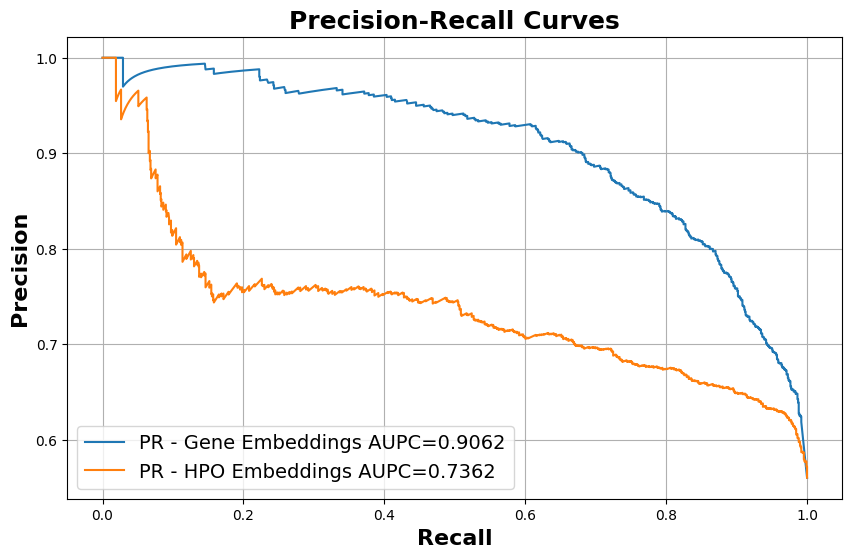

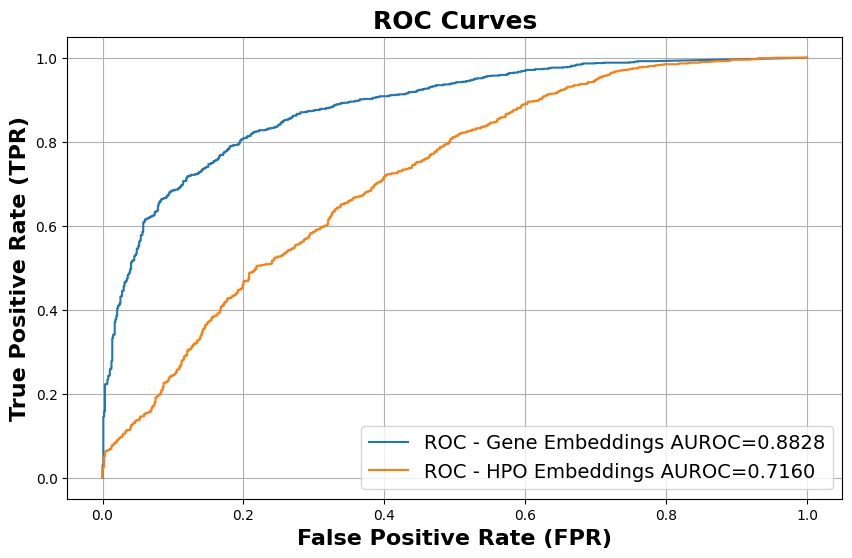

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Load the data
pr_hnet = pd.read_csv('/home/abamini/PhenoGnet/plots/pr_data_hnet_run.csv')
pr_hpo = pd.read_csv('/home/abamini/PhenoGnet/plots/pr_data_hpo_run.csv')
roc_hnet = pd.read_csv('/home/abamini/PhenoGnet/plots/roc_data_hnet_run.csv')
roc_hpo = pd.read_csv('/home/abamini/PhenoGnet/plots/roc_data_hpo_run.csv')

# Calculate AUC for PR curves
auc_pr_hnet = auc(pr_hnet['recall'], pr_hnet['precision'])
auc_pr_hpo = auc(pr_hpo['recall'], pr_hpo['precision'])

# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(pr_hnet['recall'], pr_hnet['precision'], label=f'PR - Gene Embeddings AUPC={auc_pr_hnet:.4f}')
plt.plot(pr_hpo['recall'], pr_hpo['precision'], label=f'PR - HPO Embeddings AUPC={auc_pr_hpo:.4f}')
plt.xlabel('Recall', fontsize=16, fontweight='bold')
plt.ylabel('Precision', fontsize=16, fontweight='bold')
plt.title('Precision-Recall Curves', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

# Calculate AUC for ROC curves
auc_roc_hnet = auc(roc_hnet['fpr'], roc_hnet['tpr'])
auc_roc_hpo = auc(roc_hpo['fpr'], roc_hpo['tpr'])

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(roc_hnet['fpr'], roc_hnet['tpr'], label=f'ROC - Gene Embeddings AUROC={auc_roc_hnet:.4f}')
plt.plot(roc_hpo['fpr'], roc_hpo['tpr'], label=f'ROC - HPO Embeddings AUROC={auc_roc_hpo:.4f}')
plt.xlabel('False Positive Rate (FPR)', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=16, fontweight='bold')
plt.title('ROC Curves', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
plt.grid(True)
plt.show()
